# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.
* Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком.
* Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.
* Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)"

## Обзор и предподготовка данных

In [1]:
# импорт всего необходимого
from scipy import stats as st
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest,chi2,RFE
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

In [2]:
try:
    df = pd.read_csv('/datasets/Churn.csv')
except:
    df = pd.read_csv('Churn.csv')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


С виду всё прилично, но вот данные типа RowNumber, CustomerId и Surname нам точно не понадобятся

In [3]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

По столбцу Tenure есть некоторые вопросы, нужно посмотреть из чего он состоит

In [4]:
df['Tenure'].unique()

array([ 2.,  1.,  8.,  7.,  4.,  6.,  3., 10.,  5.,  9.,  0., nan])

Особых успехов это не принесло, присутствуют все года по порядку. Оставим пока как есть, если будут проблемы, то заменим на что-нибудь. Признак тут количественно-категориальный получается, лучше всего будет заменить на 11 

In [5]:
df['Tenure'] = df['Tenure'].fillna(11)

Итого имеем несколько категориальных признаков и много количественных. Проведём кодирование категориальных признаков методом OHE и сразу же подстрахуемся от дамми-ловушки

In [6]:
df_ohe = pd.get_dummies(df, drop_first=True)

## Подготовка выборки

### Деление выборки

Для начала разделим выборку на обучающую, валидационную и тестовую. Делить будем, согласно рекомендациям, по-классике, 3:1:1. Целевой признак у нас Exited.

In [7]:
df_train, df_valid0 = train_test_split(df_ohe, test_size=0.40, random_state=12345, stratify = df_ohe['Exited']) # отделяем 40% проверочных данных
df_valid, df_test = train_test_split(df_valid0, test_size=0.50, random_state=12345,stratify = df_valid0['Exited']) # # делим их на тестовые и валидационные

In [8]:
features_train = df_train.drop('Exited', axis=1)
target_train = df_train['Exited']
features_valid = df_valid.drop('Exited', axis=1)
target_valid = df_valid['Exited']
features_test = df_test.drop('Exited', axis=1)
target_test = df_test['Exited']

### Масштабирование признаков

Так как в нашем наборе имеются количественные признаки с разным масштабом, нужно привести их к одному

In [9]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

scaler = StandardScaler()
scaler.fit(features_train[numeric])
#features_train[numeric] = scaler.transform(features_train[numeric])
#features_valid[numeric] = scaler.transform(features_valid[numeric])
#features_test[numeric] = scaler.transform(features_test[numeric])

StandardScaler()

От масштабирования в последствии пришлось отказаться, т.к. на F1 практически не влияет в случае модели случайного леса, но без масштабирования подрастает немного AUC-ROC

### Дисбаланс классов

0    7963
1    2037
Name: Exited, dtype: int64

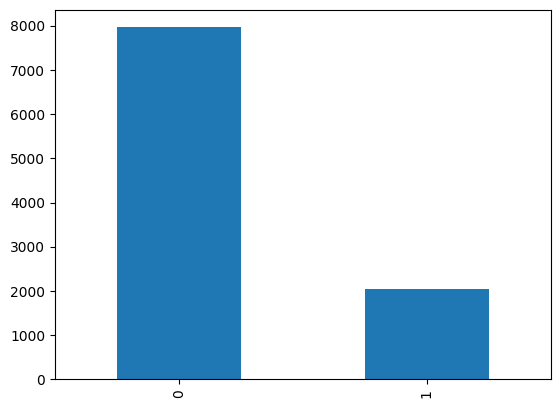

In [10]:
df['Exited'].value_counts().plot(kind="bar")
display(df['Exited'].value_counts())

Довольно сильный дисбаланс наблюдается, модель научится предсказывать не уход клиентов, а их неуход. Будем делать на него поправку

## Выбор модели

### Случайный лес с дисбалансом классов

Лес в среднем лучше всех остальных моделей, поэтому предлагаю использовать его в данном проекте. Проверим данную модель. Будем изменять гиперпараметры в цикле. Оценивать качество будем по F1 и AUC-ROC. Посмотрим как будет лучше. Сначала подберём оптимальную глубину леса

In [11]:
best_result = 0
for depth in range(1, 30):
    model = RandomForestClassifier(random_state=12345, n_estimators=20, max_depth=depth) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('F1:', f1, 'AUC-ROC:', auc_roc, 'max_depth:', depth)
    if f1 > best_result:
        best_result = f1
        max_depth = depth
print("F1 наилучшей модели на валидационной выборке:", best_result, 'max_depth:', max_depth)

F1: 0.0 AUC-ROC: 0.8047152120898611 max_depth: 1
F1: 0.17002237136465323 AUC-ROC: 0.82398204256577 max_depth: 2
F1: 0.25423728813559326 AUC-ROC: 0.8407193750615826 max_depth: 3
F1: 0.5094017094017094 AUC-ROC: 0.8568947679574342 max_depth: 4
F1: 0.5532591414944357 AUC-ROC: 0.862420250763622 max_depth: 5
F1: 0.5463258785942493 AUC-ROC: 0.8629513991526259 max_depth: 6
F1: 0.5669781931464174 AUC-ROC: 0.8667448763424968 max_depth: 7
F1: 0.5745341614906833 AUC-ROC: 0.8636788415114789 max_depth: 8
F1: 0.5758513931888545 AUC-ROC: 0.8654385592176569 max_depth: 9
F1: 0.5972850678733032 AUC-ROC: 0.870555288698394 max_depth: 10
F1: 0.6026986506746627 AUC-ROC: 0.8615134496009459 max_depth: 11
F1: 0.5924812030075188 AUC-ROC: 0.8626896738594936 max_depth: 12
F1: 0.5937031484257871 AUC-ROC: 0.862836701891812 max_depth: 13
F1: 0.6144756277695717 AUC-ROC: 0.8494917910631589 max_depth: 14
F1: 0.6046511627906976 AUC-ROC: 0.8574874987683516 max_depth: 15
F1: 0.611111111111111 AUC-ROC: 0.8548987277071632 ma

F1 перестаёт расти при достижении глубины леса 14, при этом AUC-ROC наибольший при глубине леса 14. Попробуем подобрать количество деревьев

In [12]:
best_result1 = 0
for est in range(1, 50, 1):
    model = RandomForestClassifier(random_state=12345, n_estimators=est, max_depth=14) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('F1:', f1, 'AUC-ROC:', auc_roc, 'n_estimators:', est)
    if f1 > best_result1:
        best_result1 = f1
        n_estimators = est
print("F1 наилучшей модели на валидационной выборке:", best_result1, "n_estimators", n_estimators)

F1: 0.5269607843137255 AUC-ROC: 0.7037169610306434 n_estimators: 1
F1: 0.45775729646697383 AUC-ROC: 0.7499946115380826 n_estimators: 2
F1: 0.56760374832664 AUC-ROC: 0.7778660459158538 n_estimators: 3
F1: 0.5392592592592592 AUC-ROC: 0.7942192580549808 n_estimators: 4
F1: 0.5746164574616458 AUC-ROC: 0.8148070314809341 n_estimators: 5
F1: 0.5784172661870504 AUC-ROC: 0.8178461240023649 n_estimators: 6
F1: 0.6049723756906077 AUC-ROC: 0.8194387993891024 n_estimators: 7
F1: 0.6107954545454546 AUC-ROC: 0.8255200635530594 n_estimators: 8
F1: 0.6136363636363636 AUC-ROC: 0.8277693615134496 n_estimators: 9
F1: 0.6118326118326118 AUC-ROC: 0.8340430707458864 n_estimators: 10
F1: 0.6228571428571428 AUC-ROC: 0.8344525938516111 n_estimators: 11
F1: 0.618978102189781 AUC-ROC: 0.8361407219923145 n_estimators: 12
F1: 0.6156069364161851 AUC-ROC: 0.8381898770814858 n_estimators: 13
F1: 0.6176470588235294 AUC-ROC: 0.8389434919696522 n_estimators: 14
F1: 0.6149341142020497 AUC-ROC: 0.8421042097743621 n_estima

Лучший результат на валидационных данных достигается при глубине 14 и количестве деревьев 11

### Случайный лес с балансировкой классов

Далее посмотрим как рабатает эта же модель со взвешиванием классов. Будем искать лучшую модель при изменении гиперпараметра глубины

In [13]:
best_result2 = 0
for depth in range(1, 30):
    model = RandomForestClassifier(class_weight = 'balanced', random_state=12345, n_estimators=20, max_depth=depth) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('F1:', f1, 'AUC-ROC:', auc_roc, 'max_depth:', depth)
    if f1 > best_result2:
        best_result2 = f1
        max_depth = depth
print("F1 наилучшей модели на валидационной выборке:", best_result2, 'max_depth:', max_depth)

F1: 0.5444444444444444 AUC-ROC: 0.8080275766085329 max_depth: 1
F1: 0.5706106870229007 AUC-ROC: 0.8261004778795941 max_depth: 2
F1: 0.5826484018264839 AUC-ROC: 0.8436399214208296 max_depth: 3
F1: 0.6047904191616766 AUC-ROC: 0.8560033624002364 max_depth: 4
F1: 0.6167846309403437 AUC-ROC: 0.8619583825992708 max_depth: 5
F1: 0.6187961985216474 AUC-ROC: 0.8614049105823234 max_depth: 6
F1: 0.6319148936170214 AUC-ROC: 0.8679880714848754 max_depth: 7
F1: 0.6340933767643866 AUC-ROC: 0.861587348507242 max_depth: 8
F1: 0.6406429391504018 AUC-ROC: 0.8690857781554833 max_depth: 9
F1: 0.6307151230949589 AUC-ROC: 0.8652615097546555 max_depth: 10
F1: 0.6362484157160965 AUC-ROC: 0.8655216954872401 max_depth: 11
F1: 0.6042216358839051 AUC-ROC: 0.8500137020888758 max_depth: 12
F1: 0.6065573770491803 AUC-ROC: 0.8601332335698098 max_depth: 13
F1: 0.5766016713091922 AUC-ROC: 0.8524677616021283 max_depth: 14
F1: 0.590778097982709 AUC-ROC: 0.8489506355305942 max_depth: 15
F1: 0.5911047345767576 AUC-ROC: 0.84

Здесь получили результаты лучше чем на модели с дисбалансом. Лучшая F1 на глубине 9. Далее также подберём оптимальное количество деревьев

In [14]:
best_result3 = 0
for est in range(100, 200, 5):
    model = RandomForestClassifier(class_weight = 'balanced', random_state=12345, n_estimators=est, max_depth=9) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('F1:', f1, 'AUC-ROC:', auc_roc, 'n_estimators:', est)
    if f1 > best_result3:
        best_result3 = f1
        n_estimators = est
print("F1 наилучшей модели на валидационной выборке:", best_result3, "n_estimators", n_estimators)

F1: 0.6480836236933798 AUC-ROC: 0.8730986427234211 n_estimators: 100
F1: 0.6464410735122521 AUC-ROC: 0.8725105305941472 n_estimators: 105
F1: 0.649592549476135 AUC-ROC: 0.8724504877327817 n_estimators: 110
F1: 0.649592549476135 AUC-ROC: 0.8723981426741549 n_estimators: 115
F1: 0.6480186480186481 AUC-ROC: 0.872569033894965 n_estimators: 120
F1: 0.645760743321719 AUC-ROC: 0.8727430042368708 n_estimators: 125
F1: 0.6535796766743649 AUC-ROC: 0.8727891910533058 n_estimators: 130
F1: 0.6481481481481481 AUC-ROC: 0.8724766602620947 n_estimators: 135
F1: 0.6465816917728853 AUC-ROC: 0.8723273228889548 n_estimators: 140
F1: 0.645760743321719 AUC-ROC: 0.8727183712681053 n_estimators: 145
F1: 0.6465116279069767 AUC-ROC: 0.8730001108483595 n_estimators: 150
F1: 0.6450116009280743 AUC-ROC: 0.8726521701645483 n_estimators: 155
F1: 0.6450116009280743 AUC-ROC: 0.8723273228889546 n_estimators: 160
F1: 0.6456876456876457 AUC-ROC: 0.8727537811607056 n_estimators: 165
F1: 0.6448598130841121 AUC-ROC: 0.87256

Здесь, с предварительно подобранной глубиной деревьев, результаты значительно лучше. Обе метрики подросли. Увеличение глубины сверх расчётной - пользы не приносит

Итак, наивысшее качество модели достигается при использовании модели с балансировкой, глубиной 9 и количеством деревьев 130

### Решающее дерево с дизбалансом классов 

Теперь посмотрим на решающее дерево. Будем изменять гиперпараметры в цикле. Оценивать качество будем по F1 и AUC-ROC. Посмотрим как будет лучше. Подберём оптимальную глубину леса

In [15]:
best_result4 = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(random_state=12345, max_depth=depth) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('F1:', f1, 'AUC-ROC:', auc_roc, 'max_depth:', depth)
    if f1 > best_result4:
        best_result4 = f1
        max_depth = depth
print("F1 наилучшей модели на валидационной выборке:", best_result4, 'max_depth:', max_depth)

F1: 0.0 AUC-ROC: 0.697507143560942 max_depth: 1
F1: 0.5203488372093023 AUC-ROC: 0.7539597497290373 max_depth: 2
F1: 0.5375722543352601 AUC-ROC: 0.8032503202285939 max_depth: 3
F1: 0.5206349206349208 AUC-ROC: 0.8198921999704405 max_depth: 4
F1: 0.5454545454545455 AUC-ROC: 0.849793544930535 max_depth: 5
F1: 0.5787878787878787 AUC-ROC: 0.841197408611686 max_depth: 6
F1: 0.5928057553956835 AUC-ROC: 0.8246278882155879 max_depth: 7
F1: 0.5584218512898331 AUC-ROC: 0.8186212927382008 max_depth: 8
F1: 0.5641748942172073 AUC-ROC: 0.8010148783131343 max_depth: 9
F1: 0.575070821529745 AUC-ROC: 0.7950436927283475 max_depth: 10
F1: 0.5540540540540541 AUC-ROC: 0.7658320708936841 max_depth: 11
F1: 0.544973544973545 AUC-ROC: 0.738497943147108 max_depth: 12
F1: 0.5534105534105533 AUC-ROC: 0.7265932912109567 max_depth: 13
F1: 0.5179677819083024 AUC-ROC: 0.7043227781062174 max_depth: 14
F1: 0.5321782178217822 AUC-ROC: 0.6990990491674057 max_depth: 15
F1: 0.5236363636363637 AUC-ROC: 0.6922803355010347 max_

Тут дела обстоят значительно хуже, чем у случайного леса. Посмотрим при балансировке классов

### Решающее дерево с балансировкой классов классов 

In [16]:
best_result5 = 0
for depth in range(1, 30):
    model = DecisionTreeClassifier(class_weight = 'balanced', random_state=12345, max_depth=depth, ) 
    model.fit(features_train, target_train) 
    predicted_valid = model.predict(features_valid)
    probabilities_valid = model.predict_proba(features_valid)
    probabilities_one_valid = probabilities_valid[:, 1]
    f1 = f1_score(target_valid, predicted_valid)
    auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
    print('F1:', f1, 'AUC-ROC:', auc_roc, 'max_depth:', depth)
    if f1 > best_result5:
        best_result5 = f1
        max_depth = depth
print("F1 наилучшей модели на валидационной выборке:", best_result5, 'max_depth:', max_depth)

F1: 0.4846526655896607 AUC-ROC: 0.7011897723913686 max_depth: 1
F1: 0.49801113762927607 AUC-ROC: 0.7475905877426348 max_depth: 2
F1: 0.5207100591715977 AUC-ROC: 0.7886753005222189 max_depth: 3
F1: 0.560931899641577 AUC-ROC: 0.8220206424278255 max_depth: 4
F1: 0.5546492659053834 AUC-ROC: 0.8413513646664694 max_depth: 5
F1: 0.575925925925926 AUC-ROC: 0.8270118977239136 max_depth: 6
F1: 0.5740236148955494 AUC-ROC: 0.817380406936644 max_depth: 7
F1: 0.5500910746812386 AUC-ROC: 0.7997755320721254 max_depth: 8
F1: 0.5403846153846154 AUC-ROC: 0.7821514127007587 max_depth: 9
F1: 0.5403225806451614 AUC-ROC: 0.76995655360134 max_depth: 10
F1: 0.5303186022610483 AUC-ROC: 0.7471556618878707 max_depth: 11
F1: 0.5114345114345114 AUC-ROC: 0.7280581830722238 max_depth: 12
F1: 0.5129310344827586 AUC-ROC: 0.7139504199921174 max_depth: 13
F1: 0.5105438401775806 AUC-ROC: 0.7110129384668441 max_depth: 14
F1: 0.5085518814139109 AUC-ROC: 0.7036176593753078 max_depth: 15
F1: 0.5137614678899083 AUC-ROC: 0.7083

Странно, но результаты обучения модели с балансом классов, хуже, чем на модели с дисбалансом. В целом, модель показывает худшие метрики, по сравнению с моделью случайного леса

### Логистическая регрессия c дизбалансом классов
Далее посмотрим как работает этот набор данных с моделью логистической регрессии.

In [17]:
# для логистической регрессии обязательно приведём масштаб признаков к одному, с помощью предобученного скейлера
features_train1 = features_train
features_valid1 = features_valid
features_test1 = features_test
features_train1[numeric] = scaler.transform(features_train1[numeric])
features_valid1[numeric] = scaler.transform(features_valid1[numeric])
features_test1[numeric] = scaler.transform(features_test1[numeric])


model = LogisticRegression(random_state=12345, solver='lbfgs')
model.fit(features_train1, target_train) 
predicted_valid = model.predict(features_valid1)
probabilities_valid = model.predict_proba(features_valid1)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1:', f1, 'AUC-ROC:', auc_roc)

F1: 0.30965391621129323 AUC-ROC: 0.7873990048280619


В случае использования логистической регрессии метрики качества модели оставляют желать лучшего. Нам такое вряд ли подойдёт, но проверим с балансировкой классов 

### Логистическая регрессия c балансировкой классов

In [18]:
model = LogisticRegression(random_state=12345, solver='lbfgs', class_weight = 'balanced')
model.fit(features_train1, target_train) 
predicted_valid = model.predict(features_valid1)
probabilities_valid = model.predict_proba(features_valid1)
probabilities_one_valid = probabilities_valid[:, 1]
f1 = f1_score(target_valid, predicted_valid)
auc_roc = roc_auc_score(target_valid, probabilities_one_valid)
print('F1:', f1, 'AUC-ROC:', auc_roc)

F1: 0.5285338015803336 AUC-ROC: 0.7935895777909154


Намного лучше, но до заветного порога F1 > 0.59 очень далеко

### Вывод по выбору модели

Итого, после всех наших злоключений можно подвести итоги. На валидационной выборке лучшие показатели показывают (в порядке убывания метрик):
* Модель случайного леса с балансировкой классов (Глубина 9, количество деревьев 130)
 - F1: 0.6535796766743649 AUC-ROC: 0.8727891910533058
* Модель решающего дерева с дизбалансом классов (Глубина 7)
- F1: 0.5928057553956835 AUC-ROC: 0.8246278882155879
* Логистическая регрессия с балансировкой классов
- F1: 0.40987654320987654 AUC-ROC: 0.685598642723421

Учитывая порог F1 > 0.59, при проверке модели на тестовых данных будем использовать модель случайного леса с балансировкой классов


## Проверка модели на тестовой выборке
Вот и настало время проверить модель в бою.
Проверим модель случайного леса с количеством деревьев 130 и глубиной 9

In [19]:
model = RandomForestClassifier(class_weight = 'balanced', random_state=12345, n_estimators=130, max_depth=9) 
model.fit(features_train, target_train) 
predicted_test = model.predict(features_test)
probabilities_test = model.predict_proba(features_test)
probabilities_one_test = probabilities_test[:, 1]
f1_test = f1_score(target_test, predicted_test)
auc_roc_test = roc_auc_score(target_test, probabilities_one_test)
print('F1:', f1_test, 'AUC-ROC:', auc_roc_test)

F1: 0.6028368794326241 AUC-ROC: 0.8540296845381592


Сработала и на тестовых данных. Достигнут целевой уровень метрики F1. Победааааа!

## Общие выводы

В данном проекте была обучена модель, предсказывающая уход клиентов "Бета-Банка". В процессе работы нам моделью проводилась предварительная обработка данных, затем исследовались несколько видов моделей, с подбором опитмальных гиперпараметров. По итогам исследования была найдена лучшая модель при минимальном целевом значении метрики F1 > 0.59: 
* Модель случайного леса с балансировкой классов (Глубина 9, количество деревьев 130)
 - Метрики на валидационной выборке - F1: 0.6535796766743649 AUC-ROC: 0.8727891910533058
 - Метрики на тестовой выборке - F1: 0.6088992974238875 AUC-ROC: 0.8388881948203982
 
